## Explore and Calculate Metrics for ScanBank

Calculate metrics for ScanBank-processed files.

Because our definitions of figure/figure caption differ, don't apply post processing (probably).

In [1]:
from sys import path
path.append('../')
import config

# set a seed for CV comparision?  Set to None for random
seed = 5
n_folds_cv = 5

In [2]:
# do we want to save our results to .dat files for use in other areas (like tables in latex)
save_dats = True
# which iou's to save?
ioustar = [0.9] # fig, caption
#ioustar = [0.8] # fig, caption
scorestar = 0.1
use_cv = False # only applies to saving of .dat files


# SCAN BANK -- test how well scanbank does on our images (the final test dataset)
annotation_files = '/Users/jillnaiman/MegaYolo_test/yolo_512x512_ann/' 
feature_dir = '/Users/jillnaiman/MegaYolo_test/binaries_model12_finaltest/'
###### pickle_file_loc = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/'
yolopicklename = 'binaries_model12_finaltest.pickle'
images_jpeg_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/Pages/RandomSingleFromPDFIndexed/' # default
check_json_dir = None
pdf_dir = ''
adder_dats = 'scanbank_on_ours' # what to call output file?
save_binary_dir = '/Users/jillnaiman/MegaYolo_test/'
binary_dirs = 'binaries_model12_finaltest/'# for final test set
make_sense_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/Annotations/MakeSenseAnnotations_test/'
use_pp = True


# # SCAN BANK -- test how well scanbank does on *its own set of images from ETDs*
# annotation_files = '/Users/jillnaiman/MegaYolo_scanbank/yolo_512x512_ann/' 
# feature_dir = '/Users/jillnaiman/MegaYolo_scanbank/binaries_model12_scanbank/' # not really used I think?
# #######pickle_file_loc = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/'
# yolopicklename = 'binaries_model12_scanbank.pickle' # also not sure if this is used?
# images_jpeg_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/Pages_scanbank/RandomSingleFromPDFIndexed/'
# check_json_dir = '/Users/jillnaiman/deepfigures-results/17' # check for empty json files? set to None to skip
# pdf_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/data/scanbank/etds/'
# adder_dats = 'scanbank_on_scanbank' # what to call output file?
# save_binary_dir = '/Users/jillnaiman/MegaYolo_scanbank/yolo_512x512_ann/' 
# binary_dirs = 'binaries_model12_finaltest/'# for final test set
# use_pp = False

# ------------------------

# # which metric file?
# #binary_dirs = 'binaries_model12_tfrecordz_pmcnoncom/'
# binary_dirs = 'binaries_model12_finaltest/' # final, final test

# use_valid = False





# # pp2 = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/binaries_model12_finaltest.pickle'
# # images_jpeg_dir = None
# # adder_here = ''

# # test how well detectron2 does on our images
# pp2 = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/binaries_model12_finaltest_fbdetect.pickle'
# images_jpeg_dir = None
# adder_here = 'fbdetect'
# ocr_results_dir = None
# save_binary_dir = '/Users/jillnaiman/MegaYolo_test/'
# full_article_pdfs_dir = None
# make_sense_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/Annotations/MakeSenseAnnotations_test/'
# ###binary_dirs = 'binaries_model12_finaltest/'# for final test set



# # pp2 = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/binaries_model12_tfrecordz_pmcnoncom_fbdetect.pickle'
# # images_jpeg_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/Pages_pmcnoncom/RandomSingleFromPDFIndexed/'
# # adder_here = 'pmcnon'




# #adder_dats = 'fbdetect_noncom2'



In [3]:
deepfiguresDir = '/Users/jillnaiman/deepfigures-results/' # where results are found from ScanBank

sbann_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/data/scanbank/annotations.json' # scanbank annotation's file

In [4]:
from glob import glob
if check_json_dir is not None:
    missingFiles = []
    jfiles = glob(check_json_dir + '*')
    for jf in jfiles:
        fs = glob(jf+'/*')
        fs = glob(fs[0]+'/*')
        hasJson = False
        for f in fs:
            if 'results.json' in f:
                hasJson = True
        if not hasJson:
            missingFiles.append(jf)
    # write missing to file
    if len(missingFiles) > 0:
        with open(pdf_dir+'testList_missing.csv','w') as fi:
            for m in missingFiles:
                print('/'+m.split('/')[-1]+'_p',file=fi) # weird formatting
    print('there are:', len(missingFiles), 'missing files')

In [5]:
import pickle
from sys import path
path.append('../')
##import config
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from PIL import Image
import cv2 as cv
import os
import json
from metric_utils import calc_base_metrics_allboxes_cv, calc_prec_rec_f1_cv, print_metrics_table, \
  get_years_dataframe
from general_utils import parse_annotation

In [6]:
if images_jpeg_dir is None: images_jpeg_dir = config.images_jpeg_dir

In [7]:
scoreminVec = [0.1, 0.5, 0.9] # list of minimum box "scores"
iouminVec = [0.1, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95] # list of IOU cut offs we want to explore

In [8]:
# # get pickle
pickle_file = config.metric_results_dir +yolopicklename

with open(pickle_file, 'rb') as ff:
    icombo,fnames, truebox, pdfboxes, pdfrawboxes, captionText_figcap,\
                 bbox_figcap_pars,\
                 sboxes_cleaned, slabels_cleaned, sscores_cleaned,\
                 boxes_pdf, labels_pdf, scores_pdf,\
                 boxes_heur, labels_heur, scores_heur,\
                 boxes_heur2, labels_heur2, scores_heur2,\
                 boxes_par_found, labels_par_found, scores_par_found,\
                 boxes_sq1, labels_sq1, scores_sq1,\
                 boxes_sq2, labels_sq2, scores_sq2,\
                 boxes_sq3, labels_sq3, scores_sq3,\
                 boxes_sq4, labels_sq4, scores_sq4,\
                 boxes_sq5, labels_sq5, scores_sq5,\
                 truebox1,truebox2,truebox3,rotatedImages,LABELS,boxes1, scores1, labels1 = pickle.load(ff)
pickle_file

'/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/binaries_model12_finaltest.pickle'

Create combined true boxes and found boxes.

In [9]:
# replace figures found with raw boxes?
replace_raw_box = True
# combine true figure boxes with captions boxes?
use_comb_fig_cap = False

# for AP calc
boxes_true = []; boxes_found = []; labels_found = []; scores_found = []
boxes_true_us = []; boxes_found_us = []; labels_found_us = []; scores_found_us = []
rawBox_found = []
# if there is an error with scanbank, don't count this one:
inds_drop = []
#true_pp = []

# for each annotation, get true boxes:
for ia,a in enumerate(fnames):
    # ---- get PDF boxes from before -----
    a = annotation_files + a.split('/')[-1].rstrip('.npz') + '.xml'
    imgs_name, true_boxes, pdfboxes, pdfrawboxes = parse_annotation([a], 
                                                                  LABELS, 
                                                                  parse_pdf=True, 
                                                                   check_for_file=False)
    #also save trues for our full processes
    boxes_true_us.append(truebox3[ia])
    boxes_found_us.append(boxes_sq5[ia])
    labels_found_us.append(labels_sq5[ia])
    scores_found_us.append(scores_sq5[ia])
    
    if len(true_boxes) > 0:
        truebox = true_boxes[0] # formatting mess
    else:
        truebox = []
    # no idea, but some formatting things I need to fix
    if len(pdfboxes)> 0:
        pdfboxes = pdfboxes[0]
    else:
        pdfboxes = []
    if len(pdfrawboxes)> 0:
        pdfrawboxes = pdfrawboxes[0]
    else:
        pdfrawboxes = []
        
    # ---- combine trues ---
    rotatedImage = rotatedImages[ia]
    truesComb = []
    boxes_true_fig = []; boxes_true_cap = []; boxesCombTrue = []; boxes_other = []
    # also, save fig+cap combos
    for it,tbox in enumerate(truebox):
        if LABELS[int(tbox[-1]-1)] == 'figure caption':
            boxes_true_cap.append(tbox.copy())
        elif LABELS[int(tbox[-1]-1)] == 'figure':
            if type(tbox) != tuple:
                boxes_true_fig.append(tbox.copy())
            else:
                boxes_true_fig.append(tbox)
        elif LABELS[int(tbox[-1]-1)] == 'table':
            boxes_other.append(tbox)

    # pair
    for ibb,bb in enumerate(boxes_true_fig):
        mind = 5e15; iout = -1
        xc,yc = 0.5*(bb[0]+bb[2]),bb[3]
        if rotatedImage:
            xc, yc = bb[2], 0.5*(bb[1]+bb[3])
        for ic,bc in enumerate(boxes_true_cap): # find closest to bottom, not inside a square
            xcc,ycc= 0.5*(bc[0]+bc[2]),0.5*(bc[1]+bc[3])
            d = np.sum(((xc-xcc)**2 + (yc-ycc)**2)**0.5)
            if d < mind:
                mind = d
                iout = ic
        if iout > -1: # if we found a mega-yolo-found caption, add it
            if use_comb_fig_cap:
                boxesCombTrue.append( (min(boxes_true_fig[ibb][0],boxes_true_cap[iout][0]),
                                       min(boxes_true_fig[ibb][1],boxes_true_cap[iout][1]),
                                       max(boxes_true_fig[ibb][2],boxes_true_cap[iout][2]),
                                       max(boxes_true_fig[ibb][3],boxes_true_cap[iout][3]), 
                                      LABELS.index('figure')+1) ) # 0 = placeholder tag
            else:
                boxesCombTrue.append( (min(boxes_true_fig[ibb][0],1e20),
                                       min(boxes_true_fig[ibb][1],1e20),
                                       max(boxes_true_fig[ibb][2],-1e20),
                                       max(boxes_true_fig[ibb][3],-1e20), 
                                      LABELS.index('figure')+1) ) # 0 = placeholder tag
                
            # also add caption
            boxesCombTrue.append( (boxes_true_cap[iout][0],boxes_true_cap[iout][1],
                                   boxes_true_cap[iout][2],boxes_true_cap[iout][3], 
                                  LABELS.index('figure caption')+1) ) # 0 = placeholder tag
        else: # if no, just take fig
            boxesCombTrue.append( (boxes_true_fig[ibb][0], boxes_true_fig[ibb][1], 
                                  boxes_true_fig[ibb][2], boxes_true_fig[ibb][3], 
                                  LABELS.index('figure')+1) )
    #print(len(boxes_true_fig), len(boxesCombTrue))
    #ttt += len(boxes_true_fig)
    truesComb.append(boxesCombTrue)
    boxes_true.append(boxesCombTrue)
    

        
    # get the deepfigures results
    pdfbase = a.split('/')[-1].split('_p')[0]
    dname = deepfiguresDir+pdfbase
    #allFigs = []; allScores=[]; allLabels=[]
    myRaw = []; myFigs = []; myFullFigs = []; foundLabels = []; scores = []
    try:
        f = glob(dname + '/*')[0]
    except:
        print('no file for', dname)
        f = '-1'
        import sys; sys.exit()
    # is something there?
    if os.path.isfile(f+'/'+pdfbase+'deepfigures-results.json'):
        # get json file
        with open(f+'/'+pdfbase+'deepfigures-results.json','r') as ff:
            fj = json.loads(ff.read())

        # translation coordinates info
        # get dpi
        dpi = fj['dpi']
        # get fig page with this dpi
        page = int(a.split('_p')[-1].split('.xml')[0])
        pageName = f+'/'+pdfbase+'.pdf-images/ghostscript/dpi'+str(dpi)+'/'+\
           pdfbase+'.pdf-dpi'+str(dpi)+'-page'+str(page+1).zfill(4)+'.png'
        # read and get size
        imgDraw = Image.open(pageName)
        imgDPIsize = imgDraw.size

        # only want objects on our specific page
        figsThisPage = []
        for f in fj['figures']:
            #print(f)
            if f['page'] == page:
                figsThisPage.append(f)

        # also track raw boxes
        rawBoxThisPage = []
        for ib, boxes in enumerate(fj['raw_detected_boxes']):
            if ib == page:
                rawBoxThisPage = boxes
                    
        # and finally, raw PDF figures
        pdfFiguresThisPage = []
        for pdff in fj['raw_pdffigures_output']['figures']:
            if pdff['page'] == page:
                pdfFiguresThisPage.append(pdff)
                
        # get PDF-to-YOLO
        fracx = imgDPIsize[0]/config.IMAGE_W; fracy = imgDPIsize[1]/config.IMAGE_H
        
        # grab stuffs

        # Grab raw boxes (sometimes fig boxes aren't found but they are in raw boxes)
        for b in rawBoxThisPage:
            x1 = b['x1']
            y1 = b['y1']
            x2 = b['x2']
            y2 = b['y2']
            # transform from PDF to scanned axis
            y1 = int(round(y1/fracy)); y2 = int(round(y2/fracy))
            x1 = int(round(x1/fracx)); x2 = int(round(x2/fracx))
            myRaw.append((x1,y1,x2,y2,-1))

        # get figures from deepfigs
        foundFig = False
        for f in figsThisPage:
            x1 = f['figure_boundary']['x1'] 
            y1 = f['figure_boundary']['y1']
            x2 = f['figure_boundary']['x2'] 
            y2 = f['figure_boundary']['y2']
            y1 = int(round(y1/fracy)); y2 = int(round(y2/fracy))
            x1 = int(round(x1/fracx)); x2 = int(round(x2/fracx))

            # include captions
            x1c = f['caption_boundary']['x1'] 
            y1c = f['caption_boundary']['y1']
            x2c = f['caption_boundary']['x2'] 
            y2c = f['caption_boundary']['y2']
            y1c = int(round(y1c/fracy)); y2c = int(round(y2c/fracy))
            x1c = int(round(x1c/fracx)); x2c = int(round(x2c/fracx))

            # fig/cap pairs
            if f['figure_type'] == 'Figure' and not replace_raw_box:
                foundFig = True # as to not double count raw boxes
                myFullFigs.append( (min(x1,x1c),min(y1,y1c),max(x2,x2c),max(y2,y2c)) )
                foundLabels.append( LABELS.index('figure') )
                scores.append(1.0)
                # also, get captions
                myFullFigs.append( (x1c,y1c,x2c,y2c))
                scores.append(1.0)       
                foundLabels.append( LABELS.index('figure caption') )
            elif f['figure_type'] == 'Figure' and replace_raw_box:
                # just get captions
                myFullFigs.append( (x1c,y1c,x2c,y2c))
                scores.append(1.0)       
                foundLabels.append( LABELS.index('figure caption') )
            elif f['figure_type'] == 'Table':
                xmin = min([x1,x1c]); xmax = max([x2,x2c]); ymin = min([y1,y1c]); ymax = max([y2,y2c])
                myFullFigs.append( (min(x1,x1c),min(y1,y1c),max(x2,x2c),max(y2,y2c)) )
                foundLabels.append(LABELS.index('table') )
                scores.append(1.0)
            else:
                print('no idea')
                import sys; sys.exit()
        if replace_raw_box and not foundFig: # assume raw boxes ARE figures
            for b in rawBoxThisPage:
                x1 = b['x1']
                y1 = b['y1']
                x2 = b['x2']
                y2 = b['y2']
                # transform from PDF to scanned axis
                y1 = int(round(y1/fracy)); y2 = int(round(y2/fracy))
                x1 = int(round(x1/fracx)); x2 = int(round(x2/fracx))            
                myFullFigs.append( (x1,y1,x2,y2) )
                foundLabels.append( LABELS.index('figure') )
                scores.append(1.0)
            
    else:
        inds_drop.append(ia)
                
    boxes_found.append(myFullFigs)
    labels_found.append(foundLabels)
    scores_found.append(scores)
    rawBox_found.append(myRaw)

In [10]:
len(boxes_true),len(boxes_found), len(boxes_found_us)

(830, 830, 830)

In [11]:
len(inds_drop)

33

In [12]:
boxes_true[1]

[(127.0, 264.0, 381.0, 377.0, 1),
 (100.0, 389.0, 407.0, 395.0, 2),
 (156.0, 65.0, 356.0, 105.0, 1),
 (117.0, 107.0, 391.0, 117.0, 2),
 (180.0, 199.0, 329.0, 238.0, 1),
 (148.0, 244.0, 363.0, 251.0, 2),
 (101.0, 132.0, 406.0, 166.0, 1),
 (122.0, 169.0, 389.0, 176.0, 2)]

In [13]:
boxes_found[1]

[(122, 169, 389, 173), (113, 133, 405, 385)]

In [14]:
len(fnames)

830

In [15]:
dfall = pd.DataFrame({'true_sb':boxes_true, 
                      'found_sb':boxes_found, 'labels_sb':labels_found, 'scores_sb':scores_found, 
                      'true':boxes_true_us, 
                      'found':boxes_found_us, 'labels':labels_found_us, 'scores':scores_found_us, 'fnames':fnames, 
                     'raws_sb':rawBox_found, 
                     'true_pp':boxes_true_us})

dfall = dfall.drop(dfall.index[inds_drop])
dfall = dfall.reset_index(drop=True)

boxes_true=dfall['true_sb'].values
boxes_found=dfall['found_sb'].values
labels_found=dfall['labels_sb'].values
scores_found=dfall['scores_sb'].values
fnames = dfall['fnames'].values
rawBoxes = dfall['raws_sb'].values

In [16]:
dfall

,true_sb,found_sb,labels_sb,scores_sb,true,found,labels,scores,fnames,raws_sb,true_pp
0,"[(80.0, 49.0, 433.0, 424.0, 1), (43.0, 438.0, ...","[(86, 52, 426, 430)]",[0],[1.0],"[[43.0, 438.0, 481.0, 460.0, 2.0], [43.0, 49.0...","[[42.51554506099961, 438.3030303030303, 480.56...","[1, 0]","[1.0, 1.0]",/Users/jillnaiman/MegaYolo_test/binaries_model...,"[(86, 52, 426, 430, -1)]","[[43.0, 438.0, 481.0, 460.0, 2.0], [43.0, 49.0..."
1,"[(127.0, 264.0, 381.0, 377.0, 1), (100.0, 389....","[(122, 169, 389, 173), (113, 133, 405, 385)]","[1, 0]","[1.0, 1.0]","[[100.0, 389.0, 407.0, 395.0, 2.0], [100.0, 26...","[[99.58901960784314, 388.96484848484846, 332.9...","[1, 0, 2]","[0.9956592, 0.99993587, 0.999866]",/Users/jillnaiman/MegaYolo_test/binaries_model...,"[(113, 133, 405, 385, -1)]","[[100.0, 389.0, 407.0, 395.0, 2.0], [100.0, 26..."
2,[],[],[],[],[],[],[],[],/Users/jillnaiman/MegaYolo_test/binaries_model...,[],[]
3,[],[],[],[],[],[],[],[],/Users/jillnaiman/MegaYolo_test/binaries_model...,[],[]
4,[],"[(118, 48, 390, 179), (118, 56, 390, 171)]","[3, 0]","[1.0, 1.0]","[[113.0, 46.0, 394.0, 177.0, 4.0]]","[[100.21757507324219, 38.84473419189453, 402.9...",[3],[0.9973469],/Users/jillnaiman/MegaYolo_test/binaries_model...,"[(118, 56, 390, 171, -1)]","[[113.0, 46.0, 394.0, 177.0, 4.0]]"
...,...,...,...,...,...,...,...,...,...,...,...
792,[],"[(40, 62, 463, 471)]",[0],[1.0],"[[25.0, 46.0, 475.0, 473.0, 4.0]]","[[31.224884033203125, 46.54243469238281, 492.9...",[0],[0.9998283],/Users/jillnaiman/MegaYolo_test/binaries_model...,"[(40, 62, 463, 471, -1)]","[[25.0, 46.0, 475.0, 473.0, 4.0]]"
793,"[(62.0, 45.0, 456.0, 411.0, 1), (60.0, 417.0, ...","[(60, 417, 456, 426), (61, 47, 455, 427)]","[1, 0]","[1.0, 1.0]","[[60.0, 417.0, 456.0, 427.0, 2.0], [60.0, 45.0...","[[59.83372549019608, 416.7369696969697, 456.38...","[1, 0]","[0.9999993, 0.999979]",/Users/jillnaiman/MegaYolo_test/binaries_model...,"[(61, 47, 455, 427, -1)]","[[60.0, 417.0, 456.0, 427.0, 2.0], [60.0, 45.0..."
794,"[(59.0, 63.0, 454.0, 438.0, 1), (242.0, 444.0,...","[(63, 65, 451, 448)]",[0],[1.0],"[[242.0, 444.0, 262.0, 448.0, 2.0], [59.0, 63....","[[241.99606454151908, 444.3539393939394, 262.3...","[1, 0]","[0.9995793, 0.9999996]",/Users/jillnaiman/MegaYolo_test/binaries_model...,"[(63, 65, 451, 448, -1)]","[[242.0, 444.0, 262.0, 448.0, 2.0], [59.0, 63...."
795,[],"[(51, 36, 432, 471), (61, 44, 423, 463)]","[3, 0]","[1.0, 1.0]","[[76.0, 40.0, 425.0, 408.0, 4.0]]","[[99.0333251953125, 53.67741394042969, 410.410...",[3],[0.86635315],/Users/jillnaiman/MegaYolo_test/binaries_model...,"[(61, 44, 423, 463, -1)]","[[76.0, 40.0, 425.0, 408.0, 4.0]]"


In [17]:
#dfall.iloc[0], LABELS

In [18]:
# how many true of each class?
has_obj = []
labels_done_count = np.zeros(len(LABELS))
for i in range(len(dfall)):
    for l in dfall.iloc[i]['true']:
        labels_done_count[int(l[-1]-1)] += 1
        if int(l[-1]-1) <= 1: # fig or cap
            has_obj.append(i)
print('Done per category:')
for i in range(len(LABELS)):
    print(LABELS[i], labels_done_count[i])

Done per category:
figure 475.0
figure caption 472.0
math formula 292.0
table 211.0


Test one:

In [19]:
hasbox = []
for i in range(len(dfall)):
    if len(dfall.iloc[i]['true_sb']) > 0:
        hasbox.append(i)
print(hasbox)

[0, 1, 9, 11, 15, 16, 17, 21, 22, 24, 25, 26, 31, 32, 34, 35, 39, 40, 42, 43, 44, 47, 48, 49, 51, 57, 58, 62, 64, 65, 69, 70, 71, 74, 75, 77, 79, 81, 82, 85, 88, 89, 92, 97, 98, 101, 102, 103, 105, 112, 113, 114, 116, 117, 119, 127, 128, 132, 133, 135, 136, 140, 141, 143, 146, 149, 150, 151, 153, 154, 155, 157, 158, 159, 161, 165, 170, 171, 172, 174, 175, 178, 179, 181, 194, 196, 197, 199, 201, 202, 205, 206, 207, 208, 211, 213, 214, 215, 217, 219, 220, 221, 222, 223, 231, 232, 233, 234, 236, 238, 239, 240, 244, 245, 246, 249, 250, 255, 256, 258, 260, 262, 263, 265, 266, 268, 269, 271, 272, 276, 277, 278, 280, 281, 282, 283, 285, 286, 287, 289, 291, 292, 293, 294, 295, 299, 303, 305, 308, 309, 310, 311, 312, 315, 316, 318, 321, 324, 327, 331, 334, 336, 340, 342, 343, 344, 349, 351, 352, 354, 357, 360, 364, 365, 366, 369, 371, 373, 374, 375, 380, 382, 385, 386, 387, 389, 390, 391, 394, 403, 404, 405, 406, 410, 411, 412, 414, 418, 419, 420, 421, 427, 430, 435, 436, 438, 439, 440, 443, 44

In [20]:
indb = 12

In [21]:
dfall.iloc[indb]

true_sb                                                     []
found_sb                                                    []
labels_sb                                                   []
scores_sb                                                   []
true                                                        []
found                                                       []
labels                                                      []
scores                                                      []
fnames       /Users/jillnaiman/MegaYolo_test/binaries_model...
raws_sb                                                     []
true_pp                                                     []
Name: 12, dtype: object

In [22]:
dfall.iloc[indb]['found'], dfall.iloc[indb]['labels']

([], [])

In [23]:
dfall.iloc[indb]['true'][::-1]

[]

In [24]:
# TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
#                                               [dfall.iloc[4]['true']],[dfall.iloc[4]['found']],
#                                                           [dfall.iloc[4]['labels']], 
#                                               [dfall.iloc[4]['scores']],
#                                                           n_folds_cv=n_folds_cv,
#                                                          seed=seed)
from metric_utils import new_calcs
ioumin = 0.1
trueshere = dfall.iloc[indb]['true'][::-1]
new_calcs(trueshere,dfall.iloc[indb]['found'],
          dfall.iloc[indb]['labels'],dfall.iloc[indb]['scores'],
                               np.repeat(ioumin,len(LABELS)), 
                               '1000_placeholder', np.arange(len(LABELS)))

{}

In [25]:
fnames[:2], images_jpeg_dir

(array(['/Users/jillnaiman/MegaYolo_test/binaries_model12_finaltest/1995ApJ___448__634B_p11.npz',
        '/Users/jillnaiman/MegaYolo_test/binaries_model12_finaltest/1903ApJ____18__299R_p9.npz'],
       dtype=object),
 '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/Pages/RandomSingleFromPDFIndexed/')

In [26]:
labels_found[:5]

array([list([0]), list([1, 0]), list([]), list([]), list([3, 0])],
      dtype=object)

Also read in the ScanBank annotations.

In [27]:
with open(sbann_dir,'r') as ff:
    sba = json.loads(ff.read())

In [28]:
sba.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

It seems like only figures are annotated?

In [29]:
sba['categories']

[{'supercategory': 'figure', 'id': 1, 'name': 'figure'}]

In [30]:
#sba['images']

In [31]:
cat_ids = []
for sb in sba['annotations']:
    cat_ids.append(sb['category_id'])

In [32]:
np.unique(cat_ids)

array([1])

So indeed, looks like just figures.

In [33]:
dfall.iloc[0]['fnames']

'/Users/jillnaiman/MegaYolo_test/binaries_model12_finaltest/1995ApJ___448__634B_p11.npz'

In [34]:
pageMinOurs = []
for n in dfall['fnames'].values:
    n = int(n.split('_p')[-1].rstrip('.npz'))
    pageMinOurs.append(n)
pageMinOurs = np.min(pageMinOurs)
print(pageMinOurs)

0


In [35]:
#anndir, imdir

In [36]:
# get annotations -- set in format of other DF
#fnamessba = []
#dfall = df1.set_index('name').join(df2.set_index('name'))
sb_found_boxes = []; sb_found_labels = []
names = []
for imdir,anndir in zip(sba['images'],sba['annotations']):
    boxes_found_here = []; lhere=[]
    name = imdir['file_name']
    name1 = name.split('.pdf')[0]
    page = int(name.split('page')[-1].split('.png')[0])-1 # scanbank starts numbering at 1
    name1 = feature_dir + name1 + '_p' + str(page)+'.npz'
    # only save if in our list:
    if name1 in dfall['fnames'].values.astype('str').tolist():
        names.append(name1)
        #if name in fnamessba: import sys; sys.exit()
        #fnamessba.append(name)
        #if len(anndir) > 7: import sys; sys.exit()
        # scanbank assumes 1 figure per page, or so it seems
        bb = anndir['bbox']
        h = imdir['height']; w = imdir['width']
        x1 = bb[0]*1.0/w*config.IMAGE_W; y1 = bb[1]*1.0/h*config.IMAGE_H
        x2 = (bb[0]+bb[2])*1.0/w*config.IMAGE_W; y2 = (bb[1]+bb[3])*1.0/h*config.IMAGE_H
        boxes_found_here.append((x1,y1,x2,y2))
        lhere.append(LABELS.index('figure'))
        sb_found_boxes.append(boxes_found_here) # this is pointless because only 1 fig per page
        sb_found_labels.append(lhere)
        
sb_true_boxes1 = []#; sb_true_labels1 = []
# for rest -- assume no true or found boxes
for f in dfall['fnames'].values.astype('str').tolist():
    if f in names: # have box
        ind = names.index(f)
        sb_true_boxes1.append([(sb_found_boxes[ind][0][0],
                               sb_found_boxes[ind][0][1],
                               sb_found_boxes[ind][0][2],
                               sb_found_boxes[ind][0][3], 
                              1)]) # 1 for figure
    else: # don't have
        sb_true_boxes1.append([])

In [37]:
dfall['sb_true_boxes'] = sb_true_boxes1

In [38]:
dfall.head()

,true_sb,found_sb,labels_sb,scores_sb,true,found,labels,scores,fnames,raws_sb,true_pp,sb_true_boxes
0,"[(80.0, 49.0, 433.0, 424.0, 1), (43.0, 438.0, ...","[(86, 52, 426, 430)]",[0],[1.0],"[[43.0, 438.0, 481.0, 460.0, 2.0], [43.0, 49.0...","[[42.51554506099961, 438.3030303030303, 480.56...","[1, 0]","[1.0, 1.0]",/Users/jillnaiman/MegaYolo_test/binaries_model...,"[(86, 52, 426, 430, -1)]","[[43.0, 438.0, 481.0, 460.0, 2.0], [43.0, 49.0...",[]
1,"[(127.0, 264.0, 381.0, 377.0, 1), (100.0, 389....","[(122, 169, 389, 173), (113, 133, 405, 385)]","[1, 0]","[1.0, 1.0]","[[100.0, 389.0, 407.0, 395.0, 2.0], [100.0, 26...","[[99.58901960784314, 388.96484848484846, 332.9...","[1, 0, 2]","[0.9956592, 0.99993587, 0.999866]",/Users/jillnaiman/MegaYolo_test/binaries_model...,"[(113, 133, 405, 385, -1)]","[[100.0, 389.0, 407.0, 395.0, 2.0], [100.0, 26...",[]
2,[],[],[],[],[],[],[],[],/Users/jillnaiman/MegaYolo_test/binaries_model...,[],[],[]
3,[],[],[],[],[],[],[],[],/Users/jillnaiman/MegaYolo_test/binaries_model...,[],[],[]
4,[],"[(118, 48, 390, 179), (118, 56, 390, 171)]","[3, 0]","[1.0, 1.0]","[[113.0, 46.0, 394.0, 177.0, 4.0]]","[[100.21757507324219, 38.84473419189453, 402.9...",[3],[0.9973469],/Users/jillnaiman/MegaYolo_test/binaries_model...,"[(118, 56, 390, 171, -1)]","[[113.0, 46.0, 394.0, 177.0, 4.0]]",[]


In [39]:
fnames[297]

'/Users/jillnaiman/MegaYolo_test/binaries_model12_finaltest/1903ApJ____17___48P_p14.npz'

[793  58 704]
[]
[]
[]


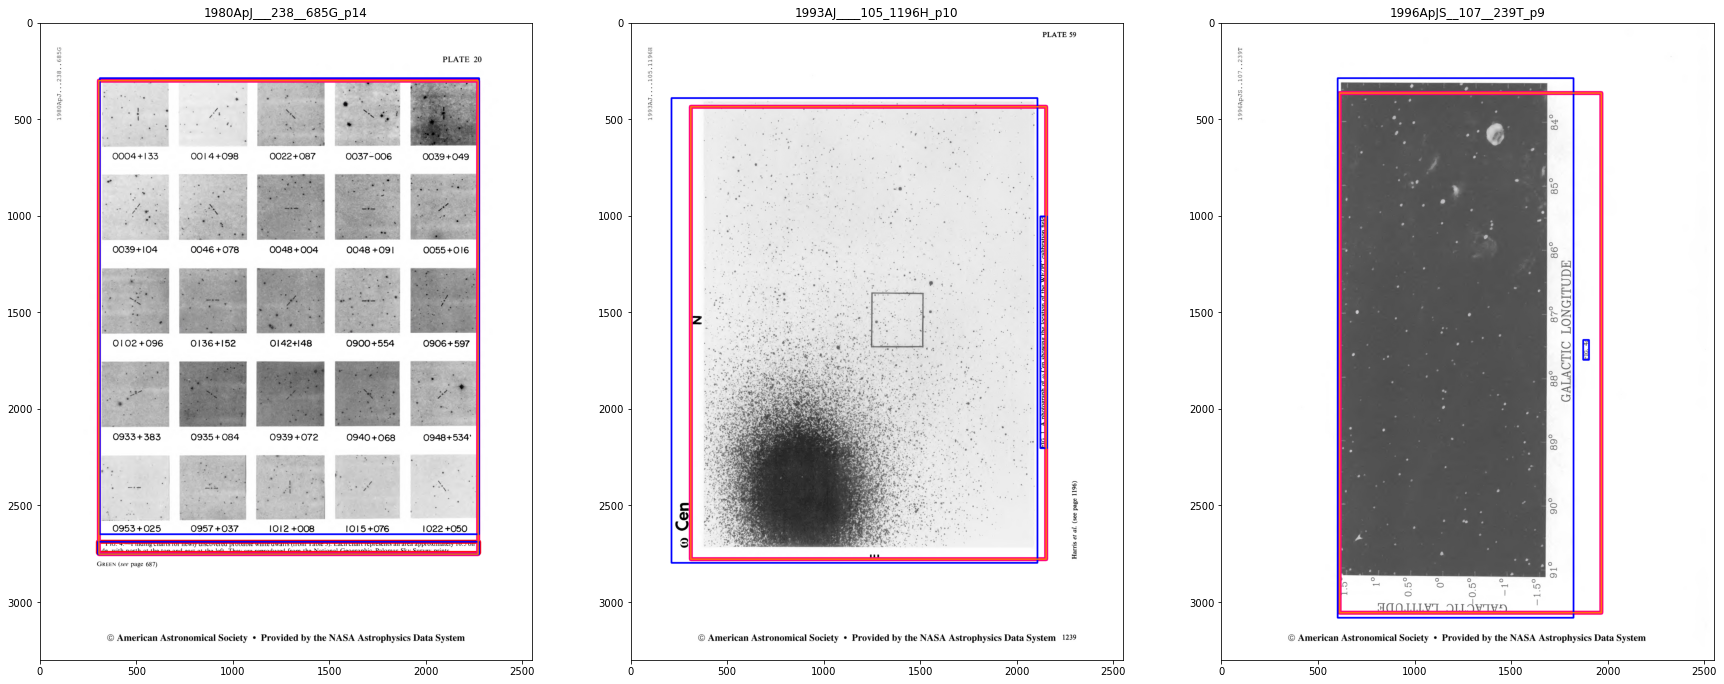

In [40]:
nr = 3
inds = np.random.randint(0,len(boxes_true), nr)
inds = np.array(has_obj)[np.random.randint(0,len(has_obj),nr)]
# has figs: 716
#inds = [184, 716, 773]
print(inds)

fig, ax = plt.subplots(1,nr,figsize=(30,20))

for i,ind in enumerate(inds):
    fn = fnames[ind].split('/')[-1].rstrip('.npz')
    img = np.array(Image.open(images_jpeg_dir+ fn+'.jpeg').convert('RGB'))

    # found in red
    for fb,cfb in zip(boxes_found[ind],labels_found[ind]):
        xmin1 = fb[0]/config.IMAGE_W*img.shape[1]
        xmax1 = fb[2]/config.IMAGE_W*img.shape[1]
        ymin1 = fb[1]/config.IMAGE_H*img.shape[0]
        ymax1 = fb[3]/config.IMAGE_H*img.shape[0]
        if LABELS[cfb] == 'figure':
            cv.rectangle(img, (round(xmin1), round(ymin1)), (round(xmax1),round(ymax1)), (255, 0, 125), 20)
        else:
            cv.rectangle(img, (round(xmin1), round(ymin1)), (round(xmax1),round(ymax1)), (255, 0, 0), 20)  

    for fb in boxes_true[ind]:
        xmin1 = fb[0]/config.IMAGE_W*img.shape[1]
        xmax1 = fb[2]/config.IMAGE_W*img.shape[1]
        ymin1 = fb[1]/config.IMAGE_H*img.shape[0]
        ymax1 = fb[3]/config.IMAGE_H*img.shape[0]
        cv.rectangle(img, (round(xmin1), round(ymin1)), (round(xmax1),round(ymax1)), (0, 0, 255), 7)  
        
    # raw boxes
    for fb in rawBoxes[ind]:
        xmin1 = fb[0]/config.IMAGE_W*img.shape[1]
        xmax1 = fb[2]/config.IMAGE_W*img.shape[1]
        ymin1 = fb[1]/config.IMAGE_H*img.shape[0]
        ymax1 = fb[3]/config.IMAGE_H*img.shape[0]
        cv.rectangle(img, (round(xmin1), round(ymin1)), (round(xmax1),round(ymax1)), (255, 125, 0), 5)  

    # sb-true boxes
    print(sb_true_boxes1[ind])
    for fb in sb_true_boxes1[ind]:
        xmin1 = fb[0]/config.IMAGE_W*img.shape[1]
        xmax1 = fb[2]/config.IMAGE_W*img.shape[1]
        ymin1 = fb[1]/config.IMAGE_H*img.shape[0]
        ymax1 = fb[3]/config.IMAGE_H*img.shape[0]
        cv.rectangle(img, (round(xmin1), round(ymin1)), (round(xmax1),round(ymax1)), (0, 255, 255), 5)  

        
    ax[i].imshow(img)
    ax[i].set_title(fn)

plt.show()

In [41]:
#boxes_true[297]
boxes_found[ind], rawBoxes[ind], boxes_true[ind]

([(123, 57, 395, 474)],
 [(123, 57, 395, 474, -1)],
 [(121.0, 45.0, 366.0, 478.0, 1), (376.0, 255.0, 382.0, 271.0, 2)])

## With our post-processing

In [42]:
from annotation_utils import get_all_ocr_files, collect_ocr_process_results, \
   get_makesense_info_and_years, get_years
from post_processing_utils import parse_annotations_to_labels, \
   get_true_boxes, get_ocr_results, get_image_process_boxes, clean_overlapping_squares, \
   clean_merge_pdfsquares, clean_merge_heurstic_captions, add_heuristic_captions, \
   clean_found_overlap_with_ocr, clean_true_overlap_with_ocr, clean_merge_squares, \
   clean_big_captions, clean_match_fig_cap, expand_true_boxes_fig_cap, \
   expand_found_boxes_fig_cap, expand_true_area_above_cap, expand_found_area_above_cap

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /Users/jillnaiman/.config/yt/ytrc is deprecated in favor of /Users/jillnaiman/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


In [43]:
if save_binary_dir is None: save_binary_dir = config.save_binary_dir
ocr_results_dir = config.ocr_results_dir
#make_sense_dir = config.make_sense_dir
if images_jpeg_dir is None: images_jpeg_dir = config.images_jpeg_dir
# from config file
annotation_dir = save_binary_dir + config.ann_name + str(config.IMAGE_H) + 'x' + str(config.IMAGE_W) + '_ann/'


In [44]:
if use_pp:
    # let's get all of the ocr files
    ocrFiles = get_all_ocr_files(ocr_results_dir=ocr_results_dir)
    # get important quantities from these files
    print('retreiving OCR data, this can take a moment...')
    ws, paragraphs, squares, html, rotations,colorbars = collect_ocr_process_results(ocrFiles)
    # create dataframe
    dfh = pd.DataFrame({'ws':ws, 'paragraphs':paragraphs, 'squares':squares, 
                       'hocr':html, 'rotation':rotations, 'colorbars':colorbars})#, 'pdfwords':pdfwords})
    dfh = dfh.drop_duplicates(subset='ws')
    dfh = dfh.set_index('ws')

retreiving OCR data, this can take a moment...
##### OCR retrieval FILE: on 1 of 2  ##### 
--- OCR retrieval: on 0 of 5515 ---
--- OCR retrieval: on 1000 of 5515 ---
--- OCR retrieval: on 2000 of 5515 ---
--- OCR retrieval: on 3000 of 5515 ---
--- OCR retrieval: on 4000 of 5515 ---
--- OCR retrieval: on 5000 of 5515 ---
##### OCR retrieval FILE: on 2 of 2  ##### 
--- OCR retrieval: on 0 of 1500 ---
--- OCR retrieval: on 1000 of 1500 ---


In [45]:
if use_pp:
    dfMakeSense = get_makesense_info_and_years(dfh,make_sense_dir=make_sense_dir)

unique = 830 pages


In [46]:
feature_dir = save_binary_dir + binary_dirs

In [47]:
#dfall
dfall.iloc[0]['fnames']

'/Users/jillnaiman/MegaYolo_test/binaries_model12_finaltest/1995ApJ___448__634B_p11.npz'

In [48]:
dfMakeSense

,filename,squares,w,h
100,1852AJ______2__158A_p4,"[(2231, 2888, 128, 165, no label)]",2550,3300
210,1896ApJ_____4__274W_p3,"[(2231, 2888, 128, 165, no label)]",2550,3300
530,1897ApJ_____5__132W_p4,"[(2240, 2986, 95, 134, no label)]",2550,3300
0,1897ApJ_____5__132W_p5,"[(2231, 2888, 128, 165, no label)]",2550,3300
630,1897ApJ_____6__371M_p5,"[(401, 368, 1687, 2249, table)]",2550,3300
...,...,...,...,...
529,1997AJ____114_2664S_p6,"[(2231, 2888, 128, 165, no label)]",2550,3300
409,1997AJ____114__265G_p2,"[(1295, 2938, 940, 103, figure caption), (1313...",2550,3300
628,1997AJ____114__272S_p4,"[(179, 1226, 1022, 113, figure caption), (202,...",2550,3300
729,1997AJ____114__655B_p0,"[(2231, 2888, 128, 165, no label)]",2550,3300


In [49]:
imgs_name, a

(array(['/Users/jillnaiman/MegaYolo_test/binaries/1907ApJ____26___18H_p14.npz'],
       dtype='<U68'),
 '/Users/jillnaiman/MegaYolo_test/yolo_512x512_ann/1907ApJ____26___18H_p14.xml')

In [50]:
!ls /Users/jillnaiman/MegaYolo_test/yolo_512x512_ann/1995ApJ___448__634B_p11.xml

/Users/jillnaiman/MegaYolo_test/yolo_512x512_ann/1995ApJ___448__634B_p11.xml


In [51]:
dfMakeSense['filename']

100    1852AJ______2__158A_p4
210    1896ApJ_____4__274W_p3
530    1897ApJ_____5__132W_p4
0      1897ApJ_____5__132W_p5
630    1897ApJ_____6__371M_p5
                ...          
529    1997AJ____114_2664S_p6
409    1997AJ____114__265G_p2
628    1997AJ____114__272S_p4
729    1997AJ____114__655B_p0
629    1997AJ____114__680A_p3
Name: filename, Length: 830, dtype: object

In [53]:
useColorbars = True

boxes_pp = []; labels_pp = []; scores_pp = []
boxes_pp2 = []; labels_pp2 = []; scores_pp2 = []
if use_pp:
    for i in range(len(dfall)):
        if i%200 == 0: print('on i=',i,'of',len(dfall))
        dfhere = dfall.iloc[i]
        #imgs_name = dfhere.name
        imgs_name = dfall.iloc[i]['fnames'].split('/')[-1].rstrip('.npz')
        a = annotation_dir+imgs_name+'.xml'
        boxes1 = dfhere['found_sb']
        scores1 = dfhere['scores_sb']
        labels1 = dfhere['labels_sb']

        # get OCR results and parse them, open image for image processing
        imgs_name_in = '/'+imgs_name+'.npz'
        dfMS = dfMakeSense.loc[dfMakeSense['filename']==imgs_name]

        backtorgb,image_np,rotatedImage,rotatedAngleOCR,bbox_hocr,\
          bboxes_words,bbsq,cbsq, rotation,bbox_par = get_ocr_results([imgs_name_in], 
                                                                      dfMakeSense,dfh,
                                                                     image_np=np.zeros([512,512]),
                                                                          images_jpeg_dir=images_jpeg_dir)

        sboxes_cleaned, slabels_cleaned, sscores_cleaned = clean_overlapping_squares(boxes1,
                                                                                     scores1,
                                                                                     labels1,
                                                                                     imgs_name_in)   

        # assume no PDF
        #pdfboxes = []; pdfrawboxes = []
        _, pdfboxes, pdfrawboxes,years_ind, _ = get_true_boxes(a,LABELS,
                                                           [],[],
                                                           annotation_dir=annotation_dir,
                                                          feature_dir=feature_dir,
                                                            check_for_file=False)

        boxes_pdf, labels_pdf, scores_pdf = clean_merge_pdfsquares(pdfboxes,
                                                               pdfrawboxes,
                                                               sboxes_cleaned, 
                                                               slabels_cleaned, 
                                                               sscores_cleaned, 
                                                               LABELS, dfMS)

        # assume no heuristics
        #bbox_figcap_pars = []
        # get figures and captions from image processing
        captionText_figcap, bbox_figcap_pars = get_image_process_boxes(backtorgb, 
                                                                           bbox_hocr, 
                                                                           rotatedImage)

        boxes_heur, labels_heur, scores_heur,\
          ibbOverlap, boxes_heur_tf  = clean_merge_heurstic_captions(boxes_pdf, 
                                                labels_pdf, scores_pdf, 
                                                bbox_figcap_pars, LABELS,dfMS)

        boxes_par_found, labels_par_found, \
          scores_par_found = clean_found_overlap_with_ocr(boxes_heur, labels_heur, 
                                                    scores_heur,bboxes_words,
                                                          bbox_par,rotation,
                                                          LABELS, dfMS, boxes_heur_tf)   

        # if figure boxes are smaller than image-processing found boxes, merge them; 
        # also, do with colorbars as well if requested
        boxes_sq1, labels_sq1, scores_sq1, bbsq = clean_merge_squares(bbsq, cbsq,
                                                                boxes_par_found, 
                                                                labels_par_found, 
                                                                scores_par_found, 
                                                                LABELS, dfMS, 
                                                               useColorbars = useColorbars)

        # if there are any huge captions -- like 75% of the area of the page or more
        #. these are wrong, so drop them
        boxes_sq2, labels_sq2, scores_sq2 = clean_big_captions(boxes_sq1,
                                                            labels_sq1,
                                                            scores_sq1, 
                                                            LABELS)

        # sometimes captions are slightly overlapping with figures -- split the 
        # difference between those where they touch on the "bottom"
        # Default to captions found with mega yolo, if there is a figure but 
        #. no caption found, then see if there is a heuristically found caption
        boxes_sq3, labels_sq3, scores_sq3 = clean_match_fig_cap(boxes_sq2,
                                                                 labels_sq2,
                                                             scores_sq2, bbsq,
                                                             LABELS, 
                                                             rotatedImage, 
                                                             rotatedAngleOCR,
                                                             dfMS)

        # again for found boxes?  I feel like maybe not the one above?
        boxes_sq4, labels_sq4, scores_sq4 = expand_found_boxes_fig_cap(boxes_sq3, 
                                                                    labels_sq3, 
                                                                    scores_sq3,
                                                                       bbsq,
                                                                    rotatedImage, 
                                                                    LABELS, dfMS)

        # same for found
        boxes_sq5, labels_sq5, scores_sq5 = expand_found_area_above_cap(boxes_sq4, 
                                                                        labels_sq4, 
                                                                        scores_sq4, 
                                                                        bbsq,
                                                                        rotatedImage, 
                                                                        LABELS, dfMS)

        # compare these to truebox1
        boxes_pp2.append(boxes_par_found)
        labels_pp2.append(labels_par_found)
        scores_pp2.append(scores_par_found)

        # compare these to truebox3
        boxes_pp.append(boxes_sq5)
        labels_pp.append(labels_sq5)
        scores_pp.append(scores_sq5)

    # save these as well
    dfall['found_sb_pp'] = boxes_pp
    dfall['classes_sb_pp'] = labels_pp
    dfall['scores_sb_pp'] = scores_pp

    dfall['found_sb_pp2'] = boxes_pp2
    dfall['classes_sb_pp2'] = labels_pp2
    dfall['scores_sb_pp2'] = scores_pp2

on i= 0 of 797
1965AJ_____70__212B_p54.jpeg something has happened with rotation -- page says angle = 180 words say angle = 0.0
1961ApJ___133__723C_p1.jpeg something has happened with rotation -- page says angle = 180 words say angle = 0.0
1952ApJ___116__122R_p20.jpeg something has happened with rotation -- page says angle = 180 words say angle = 0.0
1990AJ____100_1369S_p6.jpeg something has happened with rotation -- page says angle = 180 words say angle = 0.0
on i= 200 of 797
1994ApJ___435L__43G_p2.jpeg something has happened with rotation -- page says angle = 180 words say angle = 0.0
something bad has happened with image_to_osd on 1987ApJS___63__265W_p12.jpeg
1987ApJS___63__265W_p12.jpeg something has happened with rotation -- page says angle = -1 words say angle = 0.0
1981AJ_____86_1044H_p2.jpeg something has happened with rotation -- page says angle = 180 words say angle = 0.0
on i= 400 of 797
1989ApJ___336__655B_p2.jpeg something has happened with rotation -- page says angle = 18

In [54]:
if use_pp:
    boxes_sb_pp = dfall['found_sb_pp'].values.tolist(); 
    labels_sb_pp = dfall['classes_sb_pp'].values.tolist(); 
    scores_sb_pp = dfall['scores_sb_pp'].values.tolist()
    trueshere_pp = np.array(dfall['true_pp'].values).tolist()

In [55]:
#sb_true_boxes1

In [56]:
# use scanbank boxes?
use_sb_true = False

if not use_sb_true:
    TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
                                                  boxes_true,boxes_found,labels_found, 
                                                  scores_found,n_folds_cv=n_folds_cv,
                                                             seed=seed)
else:
    TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
                                                  sb_true_boxes1,boxes_found,labels_found, 
                                                  scores_found,n_folds_cv=n_folds_cv,
                                                             seed=seed)
    
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouminVec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


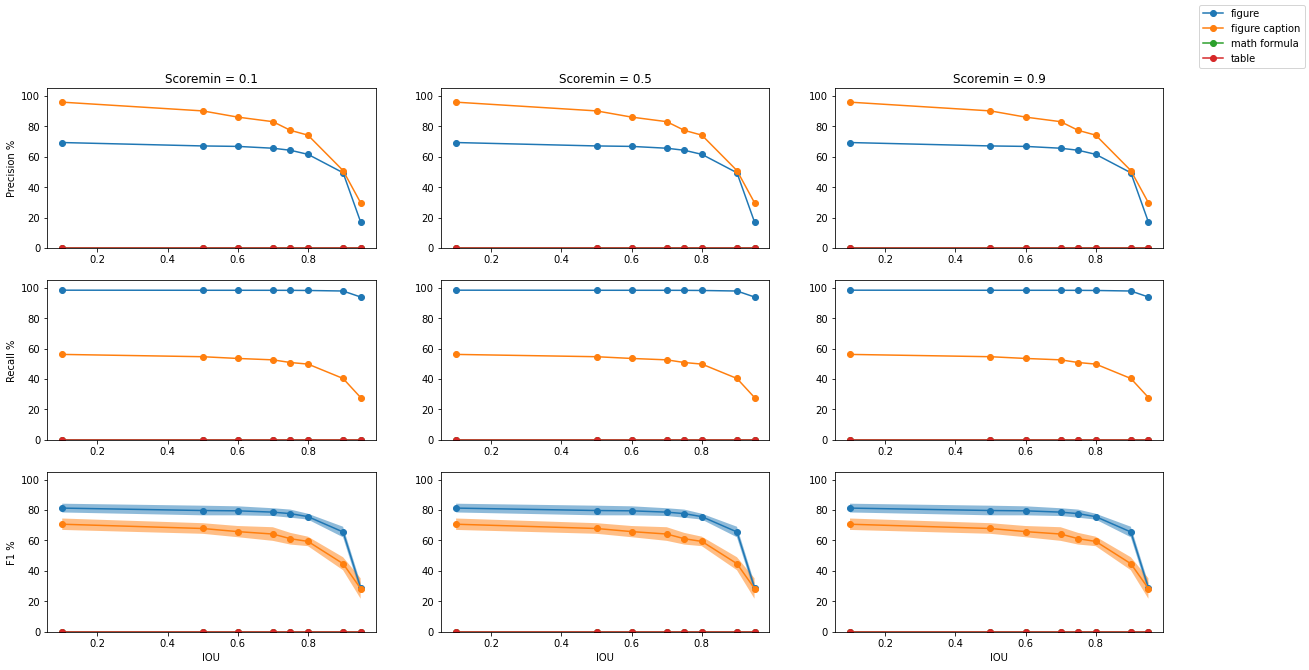

In [57]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouminVec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouminVec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouminVec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouminVec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

In [66]:
scoremin = 0.1

#Shape is: (# labels, #scores, #ious, #CV folds)
iouscheck = [0.9,0.9,0.9,0.9]
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],iouscheck,
                                              boxes_true,boxes_found,labels_found, 
                                              scores_found,n_folds_cv=n_folds_cv,
                                                         seed=seed)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               iouscheck)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, iouscheck)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.9             0.9             0.9             0.9            
# of objs       475             472             0               0              
--------------------------------------------------------------------------------------------
TP              69.9%           29.0%           nan%            nan%           
FP              71.4%           28.8%           nan%            inf%           
FN              1.7%            42.8%           nan%            nan%           
--------------------------------------------------------------------------------------------
Precision       49.5+/-4.3%     50.9+/-7.4%     0.0+/-0.0%      0.0+/-0.0%     
Recall          97.8+/-1.7%     40.4+/-4.3%     0.0+/-0.0%      0.0+/-0.0%     
F1              65.6+/-3.5%     44.7+/-4.3%     0.0+/-0.0%      0.0+/-0.0%     


## Save to .dat files if requested

In [59]:
import os
adder_here = ''
adder_dats += adder_here

In [60]:
if save_dats:
    # save too
    #out_num_name = binary_dirs.split('/')[0]+adder_dats
    out_num_name = adder_dats
    num_out_file = config.save_table_dats_dir + out_num_name
    #ioumin_per_labels = [0.1, 0.6, 0.8, 0.9, 0.95]
    #if out_num_name != 'main':
    if not os.path.exists(num_out_file+'/'):
        os.makedirs(num_out_file+'/')
    ioumin_per_labels = ioustar # just the one for our decisions
    num_out_file += '/' + out_num_name
    # how many labels to save up to?
    lend = 2

    n_cv_here = n_folds_cv
    if not use_cv: n_cv_here = 1    
    
    # save to file
    with open(num_out_file + '_score.dat','w') as fnum:
        print(scorestar, file=fnum, end='')
    with open(num_out_file + '_ncv.dat','w') as fnum:
        print(n_folds_cv, file=fnum, end='')


    TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,[scorestar],ioustar,
                                                  boxes_true,boxes_found,labels_found, 
                                                  scores_found,n_folds_cv=n_cv_here,
                                                             seed=seed)

    precision, precision_std, recall, \
      recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                                   LABELS,[scorestar],
                                                   ioustar)


    # print out total true
    for il,m in enumerate(totalTruev[:lend].sum(axis=-1)):
        with open(num_out_file + '_totTrue_'+LABELS[il].replace(' ','_')+'.dat','w') as fnum:
            print(int(m), file=fnum, end='')

    # print out TP
    for ii,iou in enumerate(ioustar):
        iouhere = str(iou).replace('.','p')

        TP = TPv[:,0,ii,:].sum(axis=-1)
        FP = FPv[:,0,ii,:].sum(axis=-1)
        FN = FNv[:,0,ii,:].sum(axis=-1)

        for il,m in enumerate(TP[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_TP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(FP[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_FP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(FN[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_FN_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            if use_cv:
                dat = str(np.round(precision[il,0,ii],1))+'$\pm$' +str(np.round(precision_std[il,0,ii],1))
            else:
                dat = str(np.round(precision[il,0,ii],1))
            with open(num_out_file + '_prec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            if use_cv:
                dat = str(np.round(recall[il,0,ii],1))+'$\pm$' +str(np.round(recall_std[il,0,ii],1))
            else:
                dat = str(np.round(recall[il,0,ii],1))
            with open(num_out_file + '_rec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            if use_cv:
                dat = str(np.round(f1[il,0,ii],1))+'$\pm$' +str(np.round(f1_std[il,0,ii],1))
            else:
                dat = str(np.round(f1[il,0,ii],1))
            with open(num_out_file + '_f1_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

    print('all done! saved in:',num_out_file)

all done! saved in: /Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/paper1/tables/tolatex/scanbank_on_ours/scanbank_on_ours


In [61]:
adder_dats_pp = adder_dats + '_withPP'

if save_dats and use_pp:
    # save too
    out_num_name = adder_dats_pp
    num_out_file = config.save_table_dats_dir + out_num_name
    #ioumin_per_labels = [0.1, 0.6, 0.8, 0.9, 0.95]
    #if out_num_name != 'main':
    if not os.path.exists(num_out_file+'/'):
        os.makedirs(num_out_file+'/')
    ioumin_per_labels = ioustar # just the one for our decisions
    num_out_file += '/' + out_num_name
    # how many labels to save up to?
    lend = 2

    # save to file
    with open(num_out_file + '_score.dat','w') as fnum:
        print(scorestar, file=fnum, end='')
    with open(num_out_file + '_ncv.dat','w') as fnum:
        print(n_folds_cv, file=fnum, end='')


    TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,[scorestar],ioustar,
                                                  trueshere_pp,boxes_sb_pp,labels_sb_pp, 
                                              scores_sb_pp,n_folds_cv=n_cv_here,
                                                             seed=seed)

    precision, precision_std, recall, \
      recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                                   LABELS,[scorestar],
                                                   ioustar)


    # print out total true
    for il,m in enumerate(totalTruev[:lend].sum(axis=-1)):
        with open(num_out_file + '_totTrue_'+LABELS[il].replace(' ','_')+'.dat','w') as fnum:
            print(int(m), file=fnum, end='')

    # print out TP
    for ii,iou in enumerate(ioustar):
        iouhere = str(iou).replace('.','p')

        TP = TPv[:,0,ii,:].sum(axis=-1)
        FP = FPv[:,0,ii,:].sum(axis=-1)
        FN = FNv[:,0,ii,:].sum(axis=-1)

        for il,m in enumerate(TP[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_TP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(FP[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_FP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(FN[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_FN_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            if use_cv:
                dat = str(np.round(precision[il,0,ii],1))+'$\pm$' +str(np.round(precision_std[il,0,ii],1))
            else:
                dat = str(np.round(precision[il,0,ii],1))               
            with open(num_out_file + '_prec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            if use_cv:
                dat = str(np.round(recall[il,0,ii],1))+'$\pm$' +str(np.round(recall_std[il,0,ii],1))
            else:
                dat = str(np.round(recall[il,0,ii],1))
            with open(num_out_file + '_rec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            if use_cv:
                dat = str(np.round(f1[il,0,ii],1))+'$\pm$' +str(np.round(f1_std[il,0,ii],1))
            else:
                dat = str(np.round(f1[il,0,ii],1))
            with open(num_out_file + '_f1_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')
    print('all done!',num_out_file)

all done! /Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/paper1/tables/tolatex/scanbank_on_ours_withPP/scanbank_on_ours_withPP


In [62]:
# trueshere_pp,boxes_sb_pp,labels_sb_pp, 
#                                               scores_sb_pp

In [63]:
len(trueshere_pp), len(boxes_sb_pp)
#labels_sb_pp
#scores_sb_pp

(797, 797)

In [65]:
    # TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,[scorestar],ioustar,
    #                                               trueshere_pp,boxes_sb_pp,labels_sb_pp, 
    #                                           scores_sb_pp,n_folds_cv=n_cv_here,
    #                                                          seed=seed)
